## Import Library

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights
import time
from torch.autograd import Variable
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
target_labels = ["female", "male"]

## Data Preparation

In [ ]:
data_path='drive/MyDrive/ai_ind/P1_FaceRecognition/Dataset'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# os.listdir(data_path)

In [ ]:
images_list = os.listdir(data_path+'/Images')
len(images_list)

In [ ]:
# load the data
# data = pd.read_csv(data_path+'/list_attribute.txt', sep="\s+", skiprows=1, usecols=['Male']) # direct version
raw_data = pd.read_csv(data_path+'/list_attribute.txt', sep="\s+", skiprows=1)
raw_data.head()

In [ ]:
all_data = raw_data.loc[:, ['Male']]
all_data.head()

,Male
000001.jpg,-1
000002.jpg,-1
000003.jpg,1
000004.jpg,-1
000005.jpg,-1


In [ ]:
# Make 0 (female) & 1 (male) labels instead of -1 & 1
all_data.loc[all_data['Male'] == -1, 'Male'] = 0
all_data.head()

,Male
000001.jpg,0
000002.jpg,0
000003.jpg,1
000004.jpg,0
000005.jpg,0


#### Select only data that contains image

In [ ]:
data = all_data[all_data.index.isin(images_list)]
len(data)

5000

In [ ]:
data.head()

,Male
000051.jpg,1
000052.jpg,1
000065.jpg,1
000166.jpg,1
000198.jpg,0


In [ ]:
print(data.index[41], data.iloc[41, 0])

001637.jpg 0


In [ ]:
idx = 41
name_id = data.index[idx]
gender_val = data.iloc[idx, 0]

img = Image.open(data_path+'/Images/'+name_id)
label = target_labels[gender_val]
print(np.asarray(img, dtype=np.uint8).shape, label)
plt.imshow(img);

In [ ]:
# train/valid/test data with 60/20/20 ratio
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
train_data, valid_data = train_test_split(train_data, test_size=0.25, random_state=0)

## Preprocessing

In [ ]:
# Create custom Dataset to accomodate single folder structure for all classes
class GenderDataset(Dataset):
  def __init__(self, csv_data, image_folder_path, transform=None):
    self.csv_data = csv_data
    self.image_folder_path = image_folder_path
    self.transform = transform

  def __len__(self):
    return len(self.csv_data)

  def __getitem__(self, idx):
    image_name = self.csv_data.index[idx]
    image_path = os.path.join(self.image_folder_path, image_name)
    image = Image.open(image_path)
    image = image.convert('RGB') # explicitly convert images into RGB format (just in case some image looks grayscale but in reality, isn’t)
    gender = self.csv_data.iloc[idx, 0]
    if self.transform is not None:
      image = self.transform(image)
    label = torch.tensor(gender, dtype=torch.long)
    return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize(178), # optional
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(), # NOTE: transforms.ToTensor() already divides pixels by 255. internally
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
batch_size = 32

train_set = GenderDataset(train_data, os.path.join(data_path, "Images"), transform=transform)
valid_set = GenderDataset(valid_data, os.path.join(data_path, "Images"), transform=transform)
test_set = GenderDataset(test_data, os.path.join(data_path, "Images"), transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

## Modeling

In [ ]:
epoch_losses_train = []
epoch_losses_test = []
epoch_accuracies_train = []
epoch_accuracies_test = []

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu=torch.cuda.is_available(), num_epochs=10):
  since = time.time()

  if use_gpu:
    model = model.to("cuda")

  best_model_wts = model.state_dict()
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'test']:
      if phase == 'train':
        #scheduler.step()
        model.train(True)  # Set model to training mode
      else:
        model.train(False)  # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for data in dataloaders[phase]:
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        if use_gpu:
          inputs = Variable(inputs.cuda())
          labels = Variable(labels.cuda())
        else:
          inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # backward + optimize only if in training phase
        if phase == 'train':
          loss.backward()
          optimizer.step()

        # statistics
        running_loss += loss.data
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.float() / dataset_sizes[phase]

      if phase == 'train':
        epoch_losses_train.append(epoch_loss.cpu())
        epoch_accuracies_train.append(epoch_acc.cpu())
      else:
        epoch_losses_test.append(epoch_loss.cpu())
        epoch_accuracies_test.append(epoch_acc.cpu())


      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = model.state_dict()
        state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
        torch.save(state,'./p1_resnet_best_point.pth')

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best test Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [ ]:
dataloaders = {"train":train_loader, "test":valid_loader}
dataset_sizes= {"train":len(train_set), "test":len(valid_set)}

## Architecture

In [ ]:
# ResNet50_Weights.DEFAULT: best available weights (currently alias for IMAGENET1K_V2) with accuracy 80.858%
# Note that these weights may change across versions
def resnet50_2():
  model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2) # 2 classes output
  return model

model = resnet50_2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [ ]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
summary(model.to(device), (3, 218, 178))
# model.state_dict()
# model

In [ ]:
use_gpu = torch.cuda.is_available()

In [ ]:
model = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.0081 Acc: 0.8963
test Loss: 0.0042 Acc: 0.9500

Epoch 1/19
----------
train Loss: 0.0020 Acc: 0.9803
test Loss: 0.0033 Acc: 0.9660

Epoch 2/19
----------
train Loss: 0.0004 Acc: 0.9973
test Loss: 0.0038 Acc: 0.9600

Epoch 3/19
----------
train Loss: 0.0003 Acc: 0.9980
test Loss: 0.0053 Acc: 0.9540

Epoch 4/19
----------
train Loss: 0.0002 Acc: 0.9983
test Loss: 0.0052 Acc: 0.9560

Epoch 5/19
----------
train Loss: 0.0005 Acc: 0.9947
test Loss: 0.0064 Acc: 0.9460

Epoch 6/19
----------
train Loss: 0.0002 Acc: 0.9977
test Loss: 0.0053 Acc: 0.9590

Epoch 7/19
----------
train Loss: 0.0005 Acc: 0.9950
test Loss: 0.0055 Acc: 0.9440

Epoch 8/19
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0056 Acc: 0.9580

Epoch 9/19
----------
train Loss: 0.0000 Acc: 1.0000
test Loss: 0.0059 Acc: 0.9610

Epoch 10/19
----------
train Loss: 0.0000 Acc: 0.9997
test Loss: 0.0057 Acc: 0.9610

Epoch 11/19
----------
train Loss: 0.0006 Acc: 0.9967
test Loss: 0.0048 Acc

In [ ]:
# model
# model.state_dict()

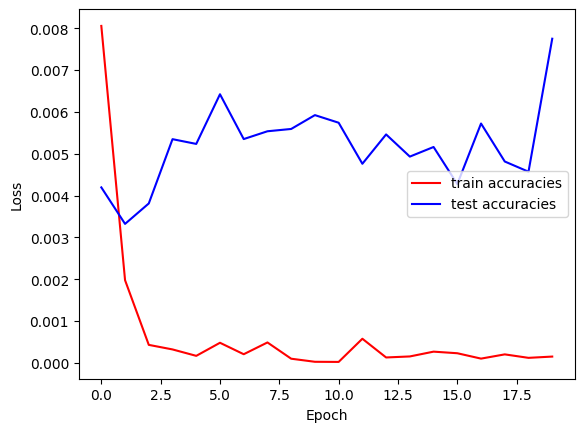

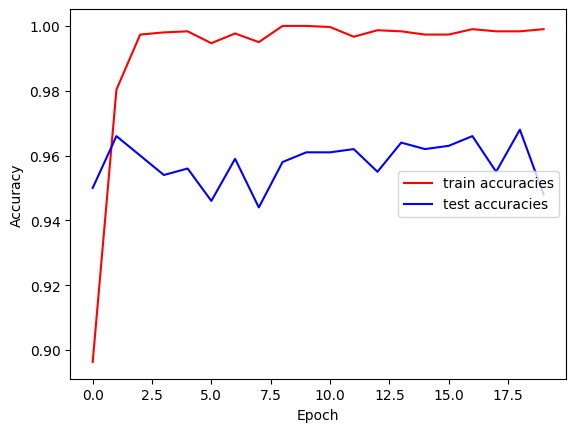

In [ ]:
plt.plot(np.arange(len(epoch_losses_train)), epoch_losses_train, 'r')
plt.plot(np.arange(len(epoch_losses_test)), epoch_losses_test, 'b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train accuracies', 'test accuracies'], loc="center right")
plt.show()

plt.plot(np.arange(len(epoch_accuracies_train )), epoch_accuracies_train , 'r')
plt.plot(np.arange(len(epoch_accuracies_test )), epoch_accuracies_test , 'b')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train accuracies', 'test accuracies'], loc="center right")
plt.show()

## Evaluation

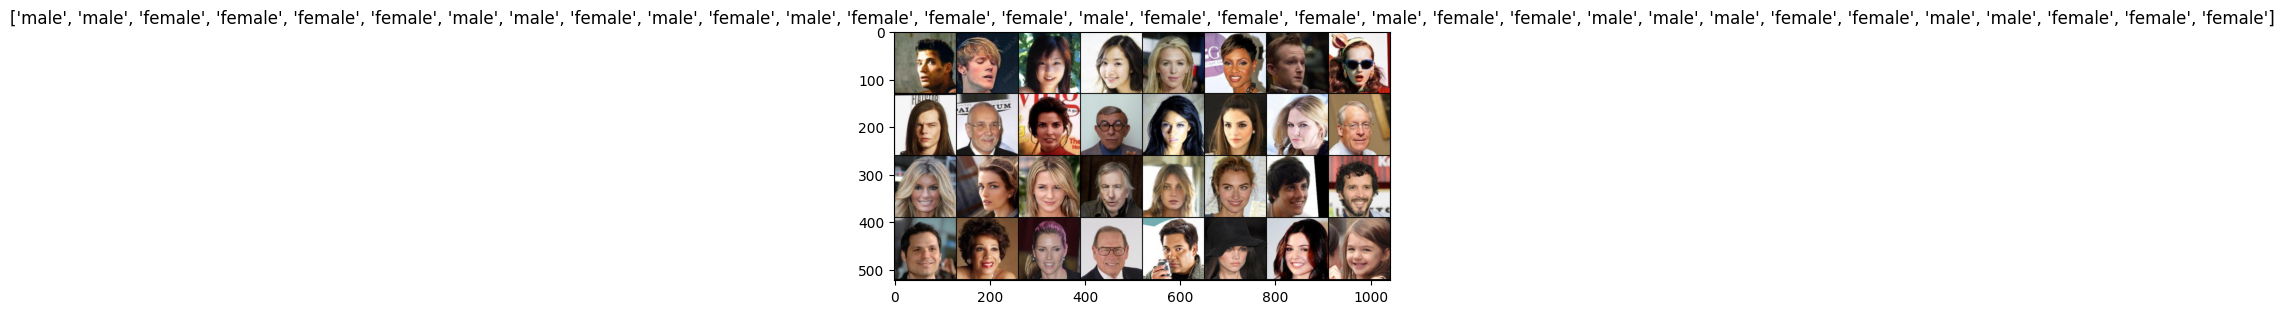

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(test_loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[target_labels[x] for x in classes])

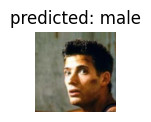

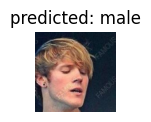

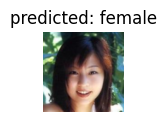

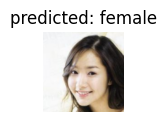

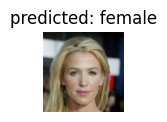

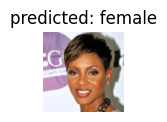

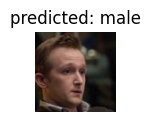

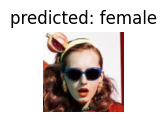

In [ ]:
import math
def evaluate_model(model, test_loader, target_labels, num_images = 8):
  if use_gpu:
    model = model.to("cuda")

  was_training = model.training
  model.eval()
  cur_images = 0

  fig = plt.figure()

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      # print(outputs)
      _, preds = torch.max(outputs, 1)
      # print(preds)

      for j in range(inputs.size()[0]):
        cur_images += 1
        # ax = plt.subplot(num_images//2, 2, cur_images)
        ax = plt.subplot(math.ceil(num_images/2), 2, cur_images)
        ax.axis('off')
        ax.set_title(f'predicted: {target_labels[preds[j]]}')
        imshow(inputs.cpu().data[j])

        if cur_images == num_images:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)


evaluate_model(model, test_loader, target_labels, 8)

# Test Saved Model

In [ ]:
# model_saved = models.resnet50(weights=ResNet50_Weights.DEFAULT)
model_saved = resnet50_2()
model_saved.load_state_dict(torch.load('/content/p1_resnet_best_point.pth')['model'])
# model_saved.state_dict()

<All keys matched successfully>

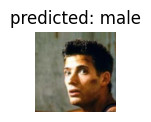

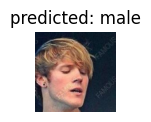

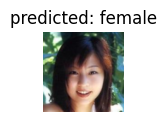

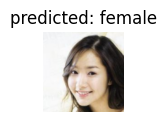

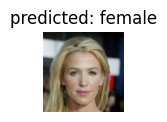

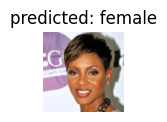

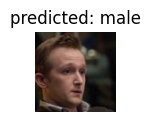

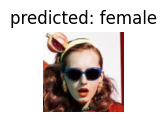

In [ ]:
evaluate_model(model_saved, test_loader, target_labels)

In [ ]:
import torchvision.transforms.functional as TF

def predict_image(image, target_labels):
  model = resnet50_2()
  model.load_state_dict(torch.load('/content/p1_resnet_best_point.pth')['model'])

  if torch.cuda.is_available():
    model = model.to("cuda")

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  input = TF.to_tensor(image)
  input.unsqueeze_(0)
  input = input.to(device)

  # outputs = model(input)
  # _, preds = torch.max(outputs, 1)

  fig = plt.figure()
  ax = plt.subplot(2//2, 2, 1)
  ax.axis('off')
  imshow(input.cpu().data[0])

  with torch.no_grad():
      model.eval()
      output = model(input)
      # print( output)
      index = output.data.cpu().numpy().argmax()
      classes = target_labels[index]
      # print(index, classes)
      # return index
      return classes

def do_predict(pict):
  # f_pred = "drive/MyDrive/ai_ind/P1_FaceRecognition/Dataset/Predict/"
  f_pred = "drive/MyDrive/ai_ind/P1_FaceRecognition/Predict/"
  image = Image.open(f'{f_pred+pict}')
  return predict_image(image, target_labels)


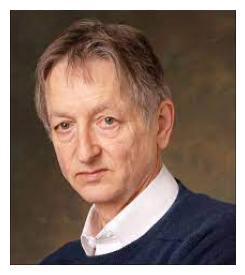

'male'

In [ ]:
do_predict("hinton.jpg")

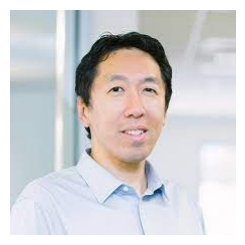

'male'

In [ ]:
do_predict("andrew.jpg")

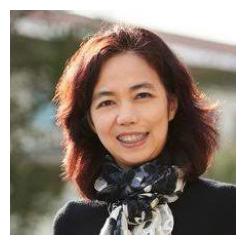

'female'

In [ ]:
do_predict("ffl.jpg")

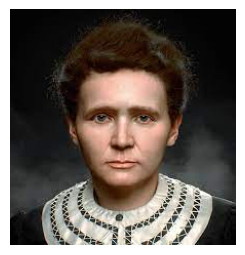

'male'

In [ ]:
do_predict("curie.jpg")

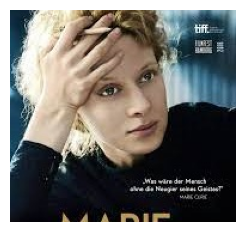

'female'

In [ ]:
do_predict("curie2.jpg")

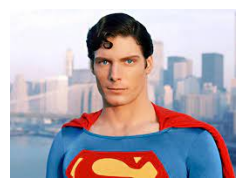

'male'

In [ ]:
do_predict("sup.jpg")

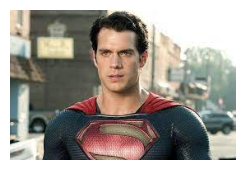

'male'

In [ ]:
do_predict("sup2.jpg")

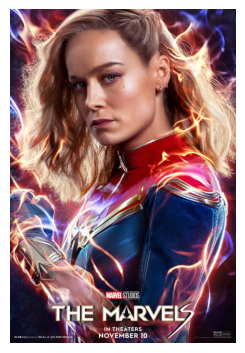

'female'

In [ ]:
do_predict("marvel.jpg")

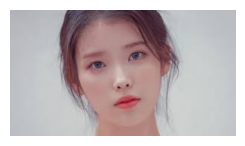

'female'

In [ ]:
do_predict("iu.jpg")

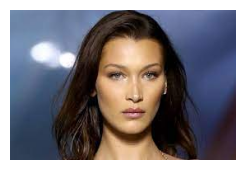

'female'

In [ ]:
do_predict("hadid.jpg")

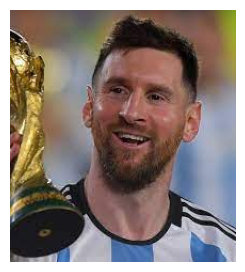

'male'

In [ ]:
do_predict("messi.jpg")

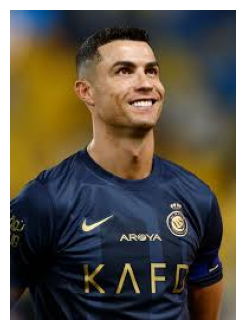

'male'

In [ ]:
do_predict("cr.jpg")

In [ ]:
do_predict("weah.jpg")

In [ ]:
do_predict("polgar.jpg")